# DAT200 CA3 2023

Kaggle username: 

### Imports

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


### Reading data

In [2]:
training = pd.read_csv(r'assets\train.csv')

### Data exploration and visualisation

In [3]:
training = training.drop(training.columns[0], axis=1)
training_target = training.iloc[:, -1]

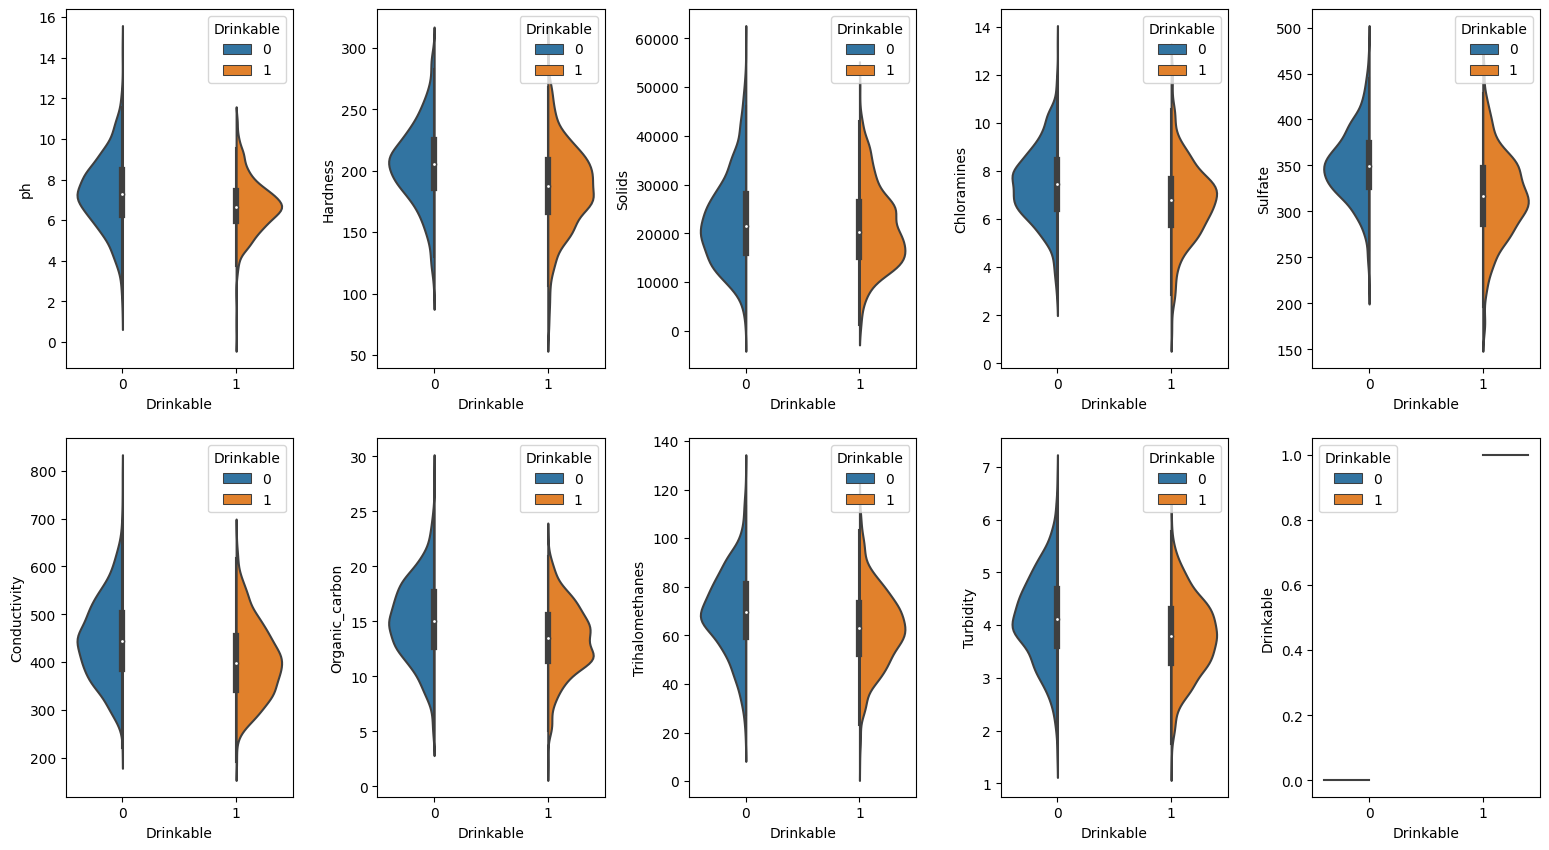

In [4]:
fig_violin, ax_violin = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
plt.tight_layout(pad=3.0)

i = 0
for row in range(2):
    for col in range(5):
        sns.violinplot(ax=ax_violin[row, col], data=training, x='Drinkable', y=training.columns[i], 
                       hue='Drinkable', split=True)
        i += 1
        
plt.show()

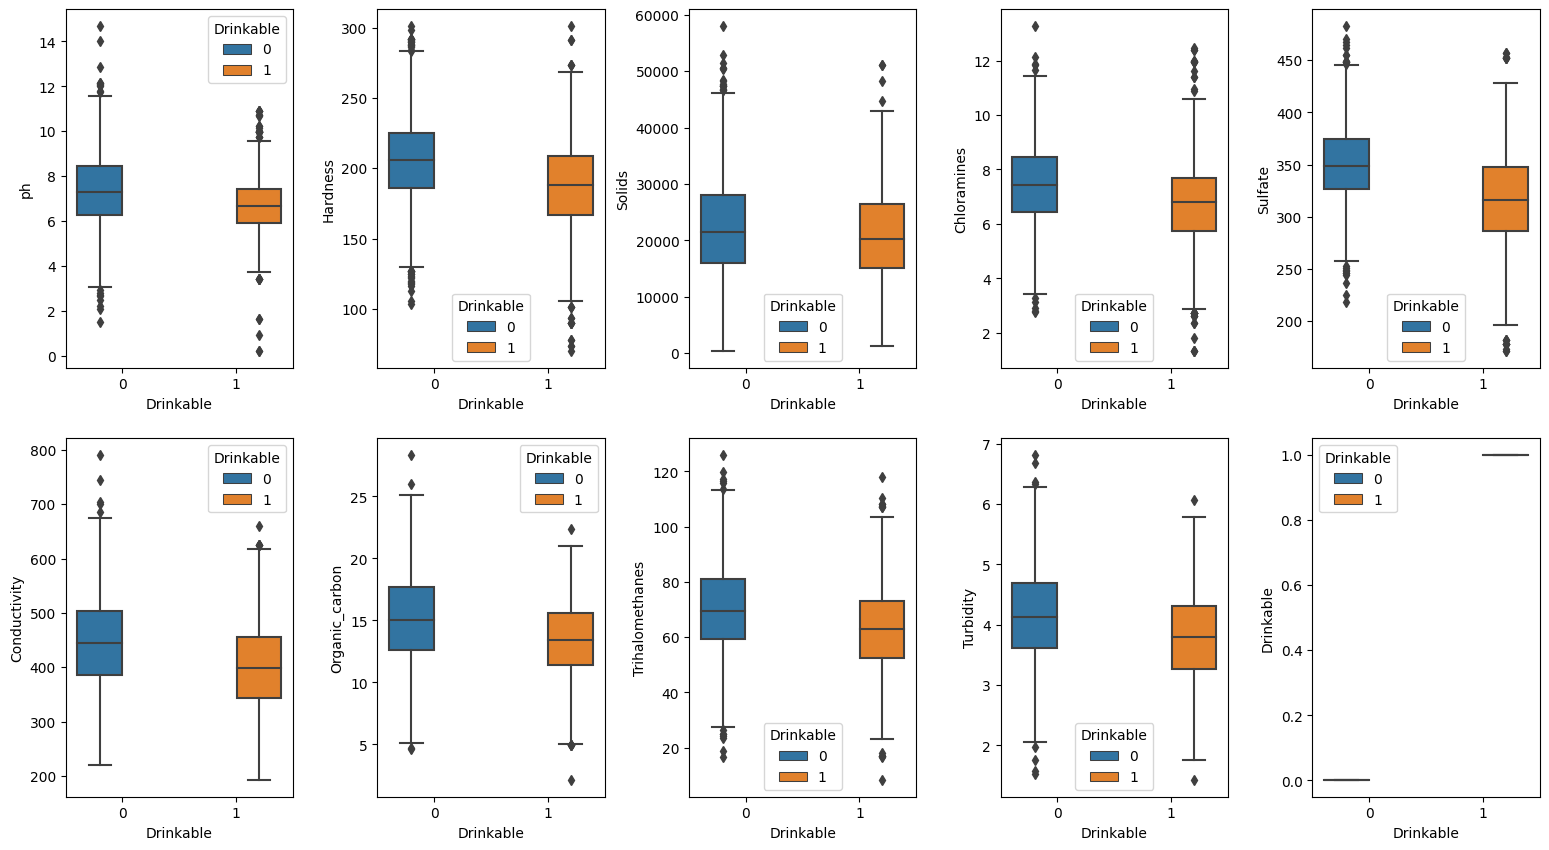

In [5]:
fig_box, ax_box = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
plt.tight_layout(pad=3.0)

i = 0
for row in range(2):
    for col in range(5):
        sns.boxplot(ax=ax_box[row, col], data=training, x='Drinkable', y=training.columns[i], 
                       hue='Drinkable')
        i += 1
        
plt.show()

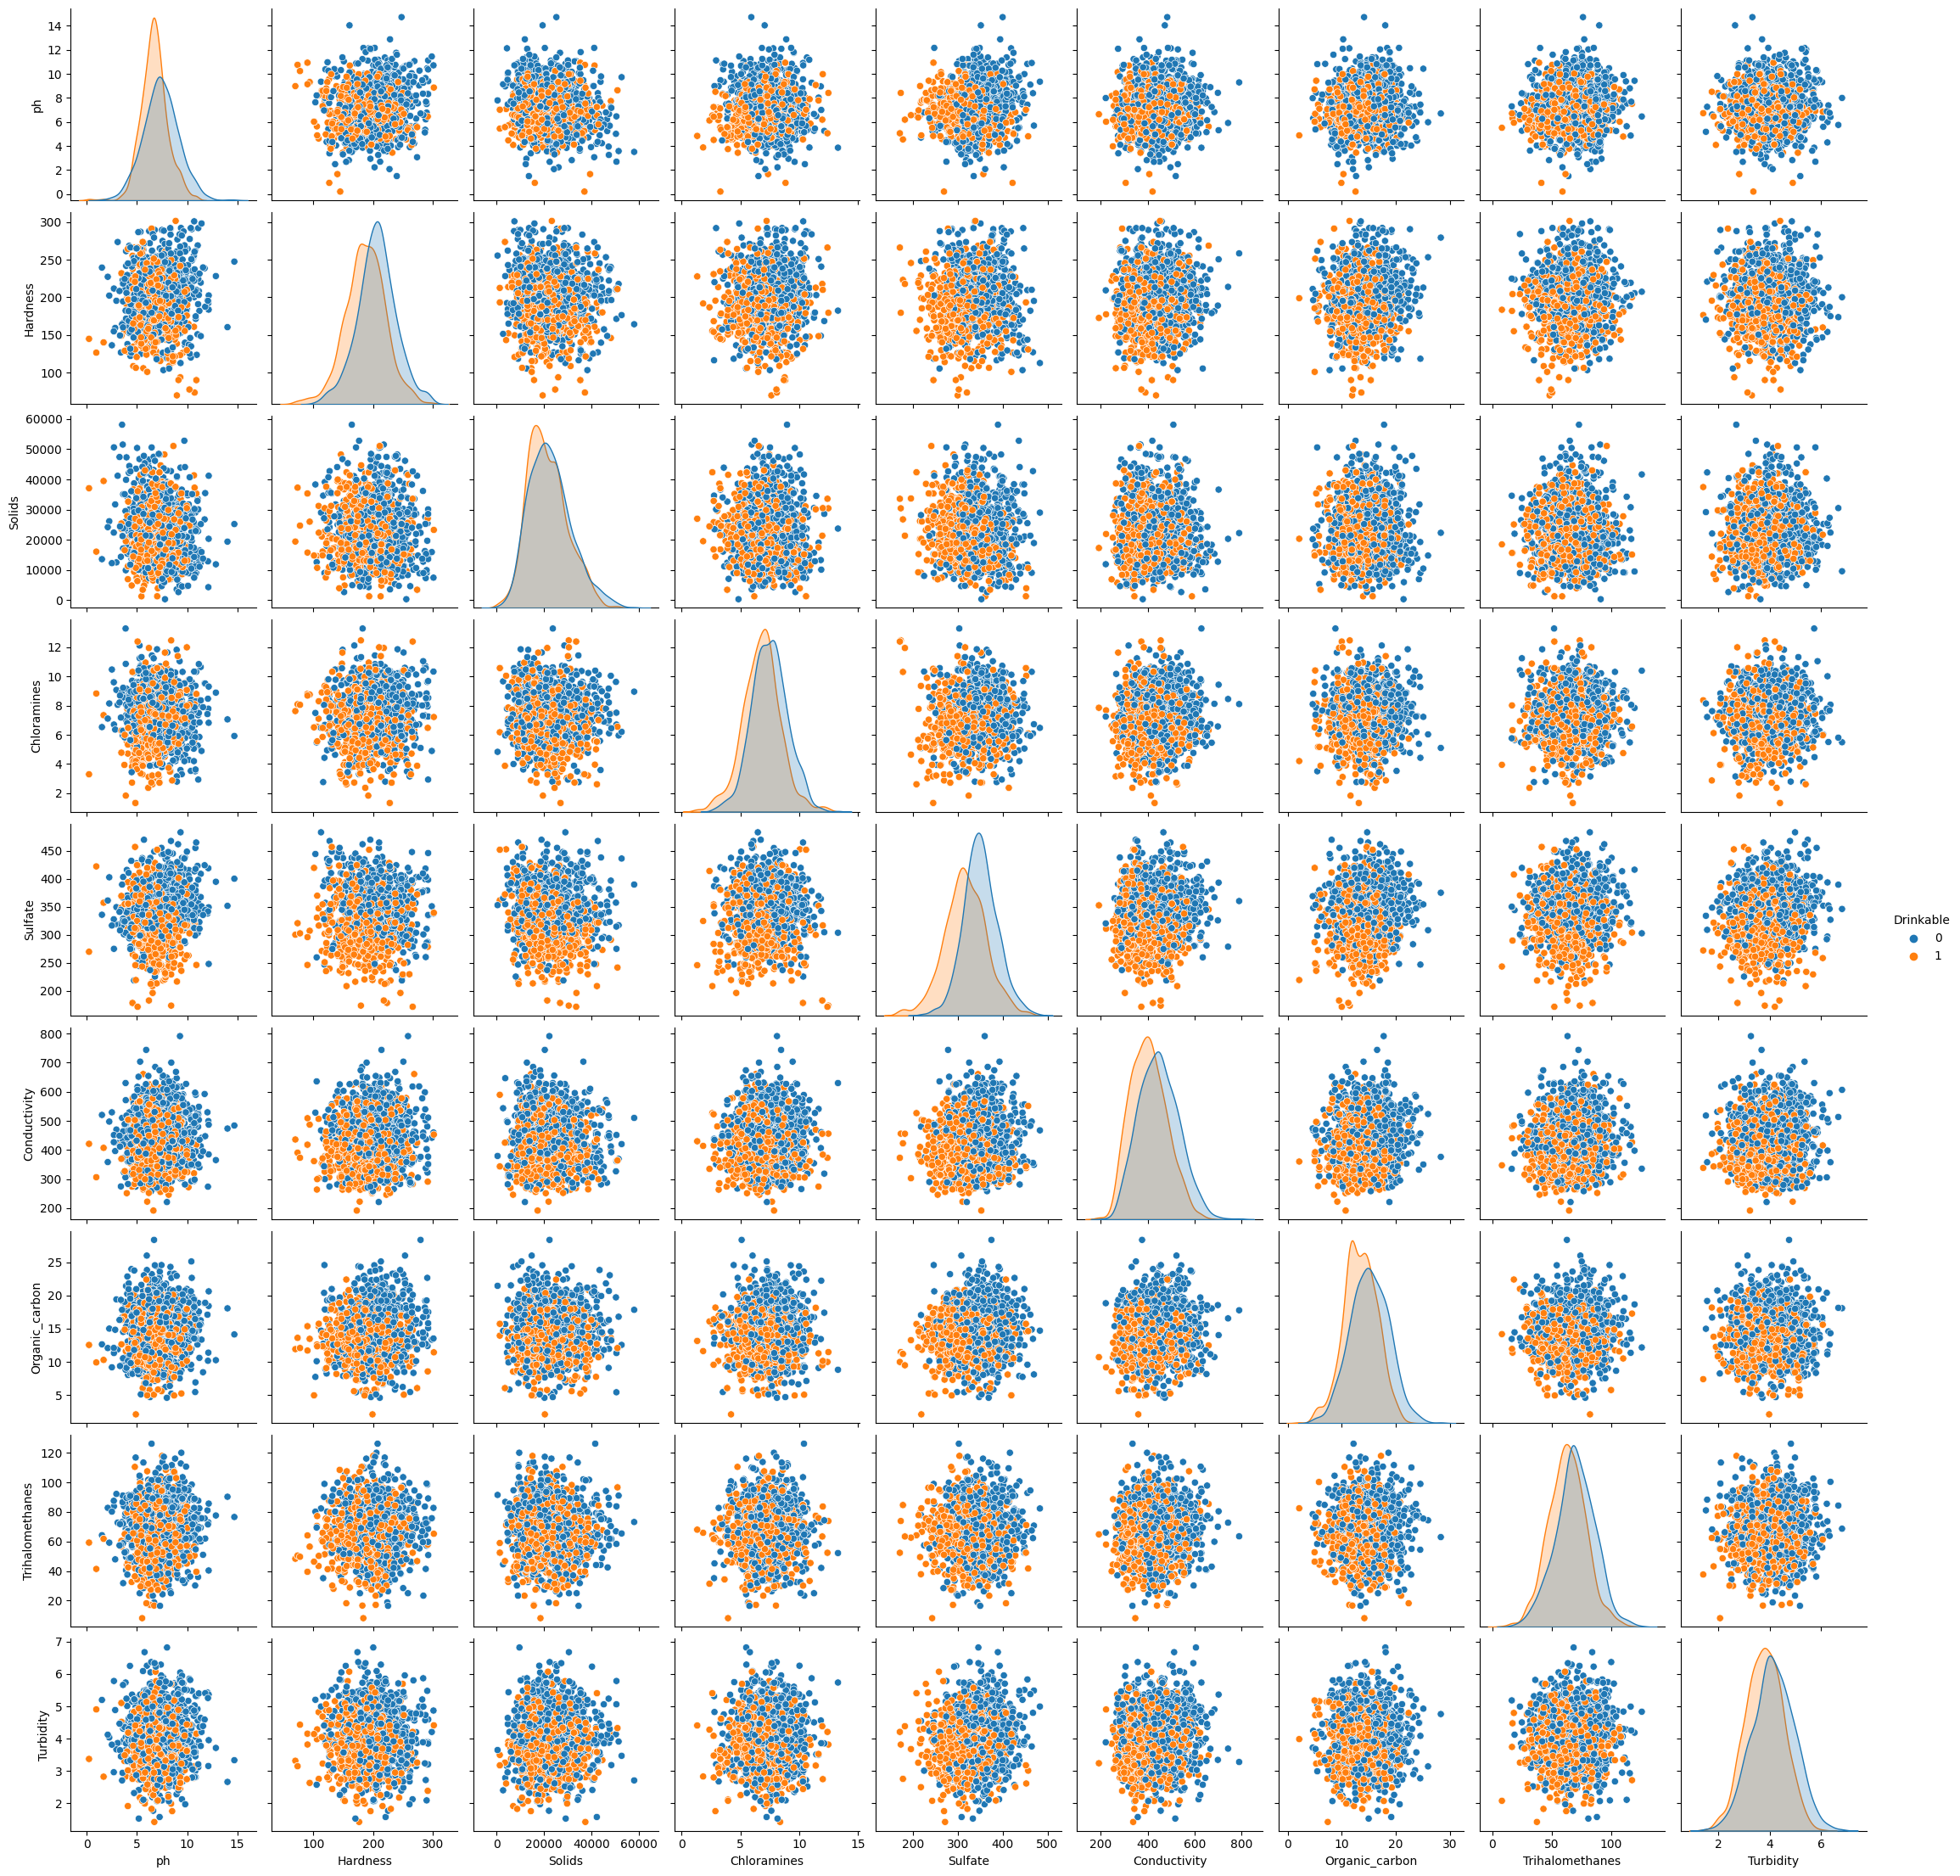

In [6]:
sns.pairplot(data=training, hue='Drinkable')
plt.show()

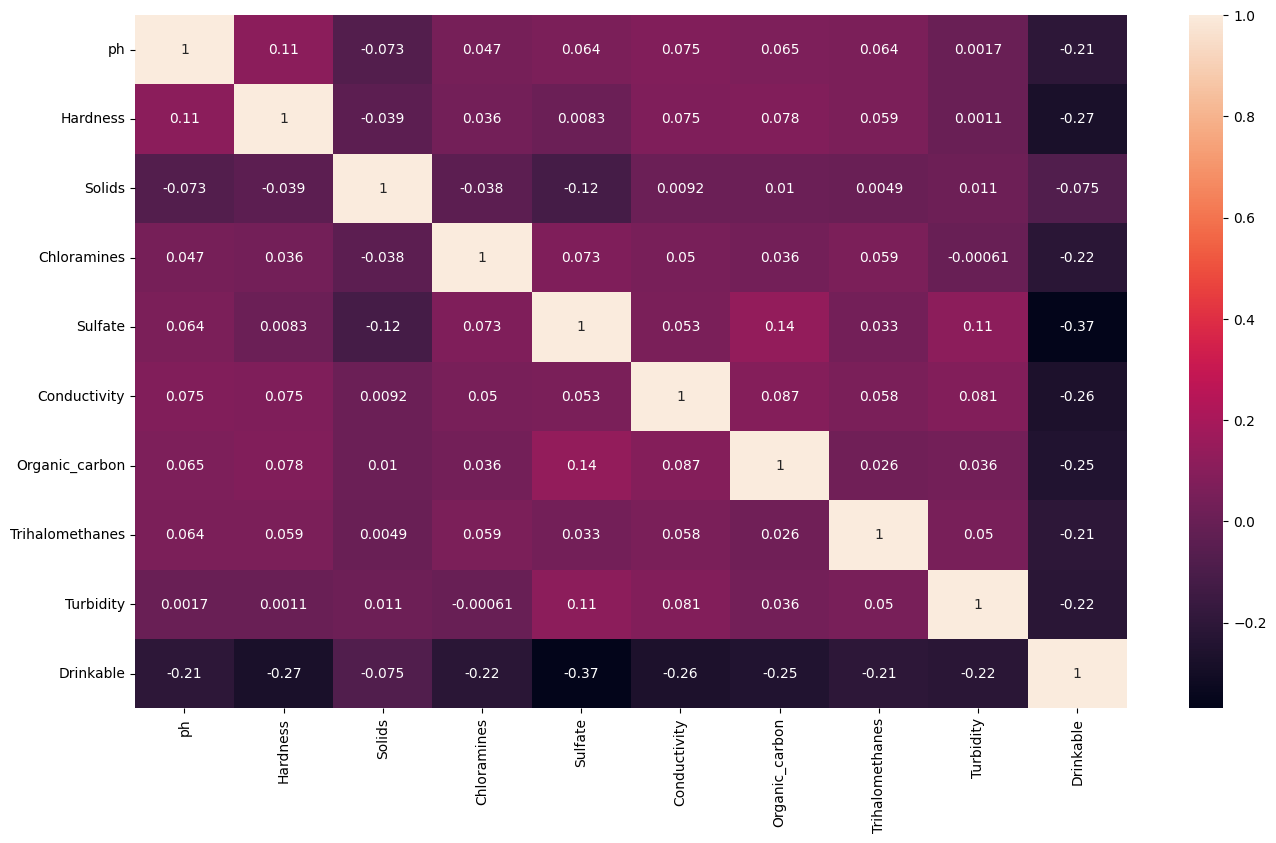

In [7]:
correlation_matrix = training.corr()
fig_corr, ax_corr = plt.subplots(figsize=(16, 9))
sns.heatmap(data=correlation_matrix, annot=True, ax=ax_corr)
plt.show()

### Data cleaning

In [8]:
ph = pd.DataFrame(training['ph'])
ph['Drinkable'] = training['Drinkable']
ph_stats = ph[ph['Drinkable'] == 1].describe()
ph_stats.head(10)

ph  Drinkable
count  1020.000000     1020.0
mean      6.717257        1.0
std       1.332566        0.0
min       0.216124        1.0
25%       5.940170        1.0
50%       6.675231        1.0
75%       7.417612        1.0
max      10.916460        1.0

In [9]:
ph_q1 = ph_stats['ph']['25%']
ph_q3 = ph_stats['ph']['75%']
ph_iqr = ph_q3 - ph_q1
print(ph_q1 - 1.5*ph_iqr)
ph_min_whisker = ph[(ph['Drinkable'] == 1) & (ph['ph'] < ph_q1 - 1.5*ph_iqr)]
ph_max_whisker = ph[(ph['Drinkable'] == 1) & (ph['ph'] > ph_q1 + 1.5*ph_iqr)]
print(ph_min_whisker.value_counts().sum())
print(ph_max_whisker.value_counts().sum())
print(f'Total outliers: {ph_max_whisker.value_counts().sum() + ph_min_whisker.value_counts().sum()}')

3.724006849144544
10
131
Total outliers: 141


~~In the first place, we could perhaps remove the bottom outliers, as it seems very unlikely that water with a pH-value less than the value of the bottom whiskeris drinkable. We can further argue for this if we were to look at the violin plot of the ph vs. drinkable plot, where we see that the outlier values stretches further downwards.~~

~~Removing all outliers by the definition that they lie outside of the whiskers will remove 50% of the samples which we see as drinkable. Perhaps not the greatest idea to remove both.~~

We have now found that we have a total of 141 outliers for the ph values where the water is classified as drinkable. At least now we have removed the most atrocious classifications of drinkable water. Though I am not knowledgeable about the other features, I still think that this is good.


In [10]:
# Remove outliers
training_ph = training.copy()
training_ph.drop(training_ph[(training_ph['Drinkable'] == 1) & (training_ph['ph'] < ph_q1 - 1.5*ph_iqr)].index, inplace=True)
training_ph.drop(training_ph[(training_ph['Drinkable'] == 1) & (training_ph['ph'] > ph_q1 + 1.5*ph_iqr)].index, inplace=True)

print((training_ph[training_ph['Drinkable'] == 1]).value_counts().sum())

879


In [11]:
training_target_ph = training_ph.iloc[:, -1]

### Data exploration after cleaning

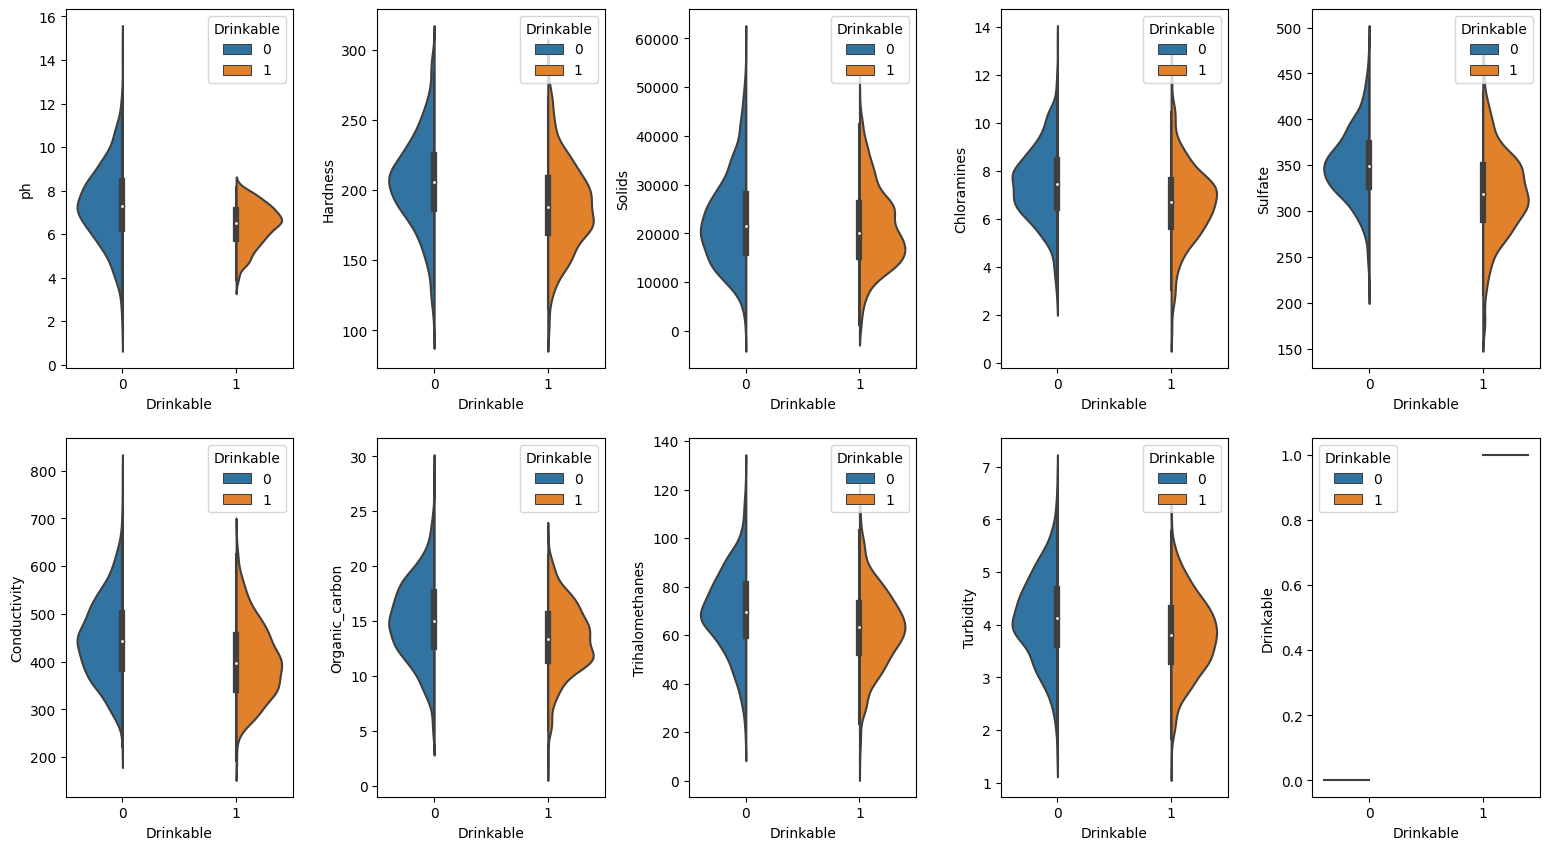

In [12]:
fig_violin_1, ax_violin_1 = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
plt.tight_layout(pad=3.0)

i = 0
for row in range(2):
    for col in range(5):
        sns.violinplot(ax=ax_violin_1[row, col], data=training_ph, x='Drinkable', y=training_ph.columns[i], 
                       hue='Drinkable', split=True)
        i += 1
        
plt.show()

### Data preprocessing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(training.iloc[:, :-1], training_target, test_size=0.3, 
                                                    stratify=training_target, random_state=1)

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [14]:
# PCA
pca = PCA(n_components=9)

X_train_PCA = pca.fit_transform(X_train_std)
X_test_PCA = pca.transform(X_test_std)

explVars = pca.explained_variance_ratio_
print(explVars)
print(np.cumsum(explVars))

[0.16014232 0.12334053 0.12027794 0.11431544 0.1043622  0.10202835
 0.09868049 0.09331375 0.08353898]
[0.16014232 0.28348285 0.40376079 0.51807623 0.62243843 0.72446678
 0.82314727 0.91646102 1.        ]


According to the PCA, we do not need to have all features present as it seems that the first 9 principle components are sufficient enough.

Plan for tomorrow:

- Start train test split for the data without the outliers in pH for drinkable water

- Start training models and make sure that they don't overfit for different parameter values. Models worth checking out may be SVM (non-linear?) and random forest

- Finally make submissions on Kaggle. Goal is 90 percent I guess?

- Is there any more tips and trick we can do to combat overfitting as get good accuracies?

#### Train test split and scaling

No changes to data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(training.iloc[:, :-1], training_target, test_size=0.3, 
                                                    stratify=training_target, random_state=1)

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [16]:
# PCA
# perhaps could try using logistic regression with this. also try with support vector machines 
pca = PCA(n_components=9)

X_train_PCA = pca.fit_transform(X_train_std)
X_test_PCA = pca.transform(X_test_std)

explVars = pca.explained_variance_ratio_
print(explVars)
print(np.cumsum(explVars))

[0.16014232 0.12334053 0.12027794 0.11431544 0.1043622  0.10202835
 0.09868049 0.09331375 0.08353898]
[0.16014232 0.28348285 0.40376079 0.51807623 0.62243843 0.72446678
 0.82314727 0.91646102 1.        ]


No pH outliers for drinkable water

In [17]:
X_train_ph, X_test_ph, y_train_ph, y_test_ph = train_test_split(training_ph.iloc[:, :-1], training_target_ph, test_size=0.3, 
                                                    stratify=training_target_ph, random_state=1)
sc = StandardScaler()
sc.fit(X_train_ph)

X_train_std_ph = sc.transform(X_train_ph)
X_test_std_ph = sc.transform(X_test_ph)

In [18]:
feat_labels = np.array(training[:-1].columns)

forest_features = RandomForestClassifier(criterion='gini', n_estimators=200, random_state=200,
                                        n_jobs=-1)
forest_features.fit(training_ph.iloc[:, :-1], training_target_ph)

importances = forest_features.feature_importances_

for importance in importances:
    print(importance)

sfm = SelectFromModel(forest_features, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
indices = np.argsort(importances)[::-1]

print(X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print(importances[indices[f]], feat_labels[indices[f]])

0.2140772277568721
0.11007753519373167
0.07658290078238347
0.09832377188391463
0.15419551003020532
0.09270580295016707
0.08526887871083844
0.08541826233290954
0.08335011035897771
3
0.2140772277568721 ph
0.15419551003020532 Sulfate
0.11007753519373167 Hardness


c:\Users\shado\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [19]:
training[['ph', 'Sulfate', 'Hardness']].head(5)

ph     Sulfate    Hardness
0  8.699665  360.083725  206.379671
1  6.563410  333.778060  175.697020
2  6.817023  317.237871  246.660238
3  7.449572  444.198272  146.902210
4  5.300541  350.452182  212.435573

#### Scaling

In [20]:
# scale actual test data
test_data_X = test.copy()
test_data_X = test_data_X.drop(test.columns[0], axis=1)

### Modelling

##### Random forest

In [38]:
def test_random_forest(data, target, n_trees, random_state, repetitions, out=False):
    training_accuracy = []
    test_accuracy = []

    for n_estimator in n_trees:
        training_pct = []
        test_pct = []
        for state in range(random_state, random_state + repetitions + 1):
            X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                                test_size=0.3, stratify=target, 
                                                                random_state=1)
            forest = RandomForestClassifier(criterion='gini', n_estimators=n_estimator, random_state=state,
                                            n_jobs=-1)
            forest.fit(X_train, y_train)
            train_score = forest.score(X_train, y_train)
            test_score = forest.score(X_test, y_test)
            training_pct.append(train_score)
            test_pct.append(test_score)

        training_avg = np.mean(training_pct)
        test_avg = np.mean(test_pct)
        training_accuracy.append(training_avg)
        test_accuracy.append(test_avg)

        if out == True:
            print(f"Average training accuracy at {n_estimator} trees is: {training_avg} ")
            print(f"Average test accuracy at {n_estimator} trees is: {test_avg} ")

    accuracy_forest = {'Training': training_accuracy,
                'Testing': test_accuracy}
    forest_accuracy = pd.DataFrame(accuracy_forest)
    forest_accuracy['num trees'] = [f'{x}' for x in range(1, len(n_trees) + 1)]

    ax = forest_accuracy.plot(xticks=forest_accuracy.index, rot=45)
    ax.set_xticklabels(forest_accuracy['num trees'])
    plt.show()

    return training_accuracy, test_accuracy

Random forest (no changes in data)

Average training accuracy at 10 trees is: 0.9933155080213903 
Average test accuracy at 10 trees is: 0.8663101604278075 
Average training accuracy at 20 trees is: 0.9983447924624393 
Average test accuracy at 20 trees is: 0.8762626262626263 
Average training accuracy at 30 trees is: 0.9994270435446905 
Average test accuracy at 30 trees is: 0.8801247771836007 
Average training accuracy at 40 trees is: 0.9998090145148969 
Average test accuracy at 40 trees is: 0.8823529411764706 
Average training accuracy at 50 trees is: 0.9997453526865292 
Average test accuracy at 50 trees is: 0.884432560903149 
Average training accuracy at 60 trees is: 0.9998090145148969 
Average test accuracy at 60 trees is: 0.8841354723707666 
Average training accuracy at 70 trees is: 0.9998726763432646 
Average test accuracy at 70 trees is: 0.8848781937017232 
Average training accuracy at 80 trees is: 0.9999363381716322 
Average test accuracy at 80 trees is: 0.8859180035650625 
Average training accuracy at 90 trees is:

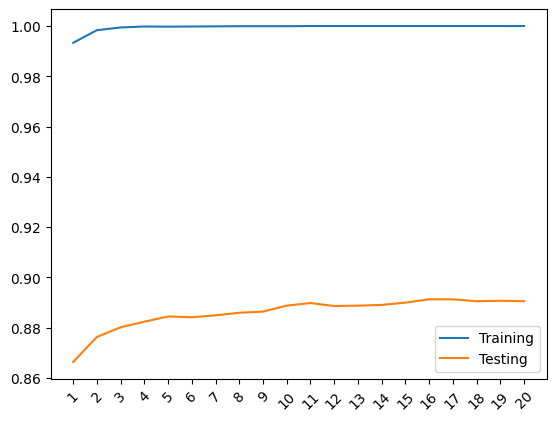

In [39]:
num_trees = [10 * x for x in range(1, 20 + 1)]

training_accuracy, test_accuracy = test_random_forest(training.iloc[:, :-1], training_target, 
                                                      num_trees, 250, 10, out=True)

In [40]:
np.max(test_accuracy) # find for how many trees this occured.
np.where(test_accuracy == np.max(test_accuracy))
print(num_trees[16])

170


No pH outliers

Average training accuracy at 800 trees is: 1.0 
Average test accuracy at 800 trees is: 0.8942583732057415 
Average training accuracy at 900 trees is: 1.0 
Average test accuracy at 900 trees is: 0.8952153110047846 
Average training accuracy at 1000 trees is: 1.0 
Average test accuracy at 1000 trees is: 0.8952153110047846 


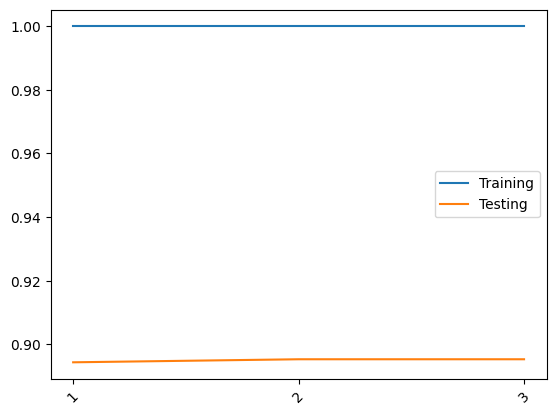

In [50]:
num_trees = [x * 100 for x in range(8, 11)] # 0.8952153110047846 
training_accuracy, test_accuracy = test_random_forest(training_ph.iloc[:, :-1], training_target_ph, 
                                                      num_trees, 250, 10, out=True)

In [47]:
np.max(test_accuracy) # find for how many trees this occured.

np.where(test_accuracy == np.max(test_accuracy))
print(num_trees[16])

170


### Kaggle submission

In [61]:
test_data = pd.read_csv(r'assets\test.csv')

In [74]:
forest_model = RandomForestClassifier(criterion='gini', n_estimators=800, random_state=255, 
                                      n_jobs=-1)

forest_model.fit(training_ph.iloc[:, :-1], training_target_ph)
training_score = forest_model.score(training_ph.iloc[:, :-1], training_target_ph)
print(training_score)

test_predictions = forest_model.predict(test_data.iloc[:, 1:])
print(test_predictions)


1.0
[1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0
 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0
 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1
 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1]


In [80]:
my_submission = pd.DataFrame({'index': list(range(len(test_predictions))), 'Drinkable': test_predictions})

In [82]:
my_submission.to_csv('submission.csv', index=False)